In [1]:
import tensorflow as tf

from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from math import ceil
from keras.applications.vgg16  import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping

from PIL import Image

import os
import numpy as np
import matplotlib.pyplot as plt


In [12]:
PATH = r'C:\Users\Rania Fradi\OneDrive\Bureau\Le moi\II\pfa\Dataset-20221017T211714Z-001\Dataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')


# print (test_dir)


# Get number of files in each directory. The train and validation directories
# each have the subdirectories "zeyneb" and "rania".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])


# Variables for pre-processing and training.
batch_size = 16
epochs = 5
IMG_HEIGHT = 224 #the model VGG is designed to work on 224 x 224 images
IMG_WIDTH = 224

In [13]:
# Create image generators for each of the three image data sets (train, validation, test)
# to read / decode the images and convert them into floating point tensors.

train_image_generator = ImageDataGenerator(rescale = 1.0/255.0)
validation_image_generator = ImageDataGenerator(rescale = 1.0/255.0)

train_data_gen = train_image_generator.flow_from_directory(
    directory = train_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True
)


val_data_gen = validation_image_generator.flow_from_directory(
    directory = validation_dir,
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = False
)


Found 64 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


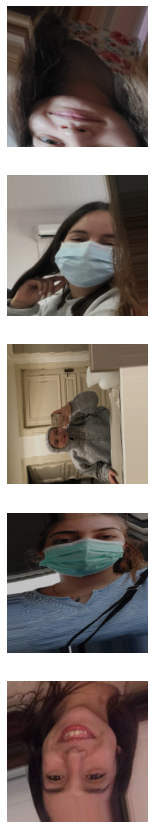

In [20]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
train_image_generator = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range=(0.7, 1),
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
    )

: 

Found 64 images belonging to 2 classes.


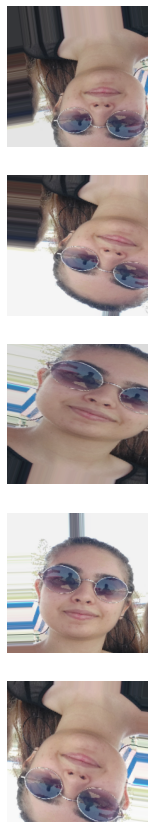

In [22]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    shuffle = True)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [17]:
n = 10

augmented_image_folder = os.path.join(r'C:\Users\Rania Fradi\OneDrive\Bureau\Le moi\II\pfa\Dataset-20221017T211714Z-001\Dataset', 'face_dataset_train_aug_images')
if not os.path.exists(augmented_image_folder):
    os.makedirs(augmented_image_folder)  # create folder if doesn't exist

train_data_gen.save_to_dir = augmented_image_folder
train_data_gen.save_format = 'jpg'

# If 'save_to_dir' is set, `next()` method
# will generate `batch_size` images each time 
# and save them to 'save_to_dir' folder

for i in range(n):
    print("Step {} of {}".format(i+1, n))
    train_data_gen.next()
    print("\tGenerate {} random images".format(train_data_gen.batch_size))

print("\nTotal number images generated = {}".format(n*train_data_gen.batch_size))

Step 1 of 10
	Generate 16 random images
Step 2 of 10
	Generate 16 random images
Step 3 of 10
	Generate 16 random images
Step 4 of 10
	Generate 16 random images
Step 5 of 10
	Generate 16 random images
Step 6 of 10
	Generate 16 random images
Step 7 of 10
	Generate 16 random images
Step 8 of 10
	Generate 16 random images
Step 9 of 10
	Generate 16 random images
Step 10 of 10
	Generate 16 random images

Total number images generated = 160


In [23]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # 3 for the RGB layers

In [25]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# When loading a given model,
# the “include_top” argument can be set to False, in which case the 
# fully-connected output layers of the model used to make predictions is 
# not loaded, allowing a new output layer to be added and trained.

base_model.trainable = False # This is called "freezing" the layer: the
# state of a frozen layer won't be updated during training (either when training
# with fit() or when training with any custom loop that relies on 
# trainable_weights to apply gradient updates)

for layer in base_model.layers:
    layer.trainable = False

In [26]:
from glob import glob

folders = glob(r'C:\Users\Rania Fradi\OneDrive\Bureau\Le moi\II\pfa\Dataset-20221017T211714Z-001\Dataset\train\*')

x =  Flatten()(base_model.output) #Return a copy of the array collapsed into one dimension
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = prediction)

In [27]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=3,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [28]:
#Compiling the model

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

In [29]:
history = model.fit(
    train_data_gen ,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_data_gen)

model.save("face_rec.h5")

Epoch 1/5
4/4 [==============================] - ETA: 0s - loss: 12.6242 - accuracy: 0.4688
Epoch 1: val_loss improved from inf to 11.73142, saving model to models\face_classifier.h5
4/4 [==============================] - 9s 2s/step - loss: 12.6242 - accuracy: 0.4688 - val_loss: 11.7314 - val_accuracy: 0.5652
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 6.5696 - accuracy: 0.5625
Epoch 2: val_loss improved from 11.73142 to 2.58188, saving model to models\face_classifier.h5
4/4 [==============================] - 8s 2s/step - loss: 6.5696 - accuracy: 0.5625 - val_loss: 2.5819 - val_accuracy: 0.6957
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 5.1827 - accuracy: 0.6406
Epoch 3: val_loss did not improve from 2.58188
4/4 [==============================] - 8s 2s/step - loss: 5.1827 - accuracy: 0.6406 - val_loss: 3.3451 - val_accuracy: 0.7391
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 3.8653 - accuracy: 0.5625
Epoch 4: val_loss impr

In [30]:
from keras.models import load_model

model = load_model(r'C:\Users\Rania Fradi\OneDrive\Bureau\Le moi\II\pfa\face_rec.h5')

In [31]:
train_data_gen.class_indices

{'rania': 0, 'zeyneb': 1}

In [32]:
#trainsforming the classifier into a detector
import cv2
import numpy as np


face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detector(img, size=0.5):

    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces == ():
        return img, []

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        roi = img[y:y+h, x:x+w]
        roi = cv2.resize(roi, (224, 224))
    return img, roi

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    #capture frame by frame
    ret, frame = cap.read()
    image, face = face_detector(frame)

    face=np.array(face)
    face=np.expand_dims(face,axis=0)
    
    if face.shape==(1,0):
        cv2.putText(image,"I don't know", (100, 120), cv2.FONT_HERSHEY_COMPLEX, 1, (255,120,150), 2)
        cv2.imshow('Face Recognition',image)
    else:
        result=model.predict(face)
        print("RESULT",result[0][0])
        if (result[0][0]) == 1.0:
            cv2.putText(image,"ZEYNEB", (100, 120), cv2.FONT_HERSHEY_COMPLEX, 1, (255,120,150), 2)
            cv2.imshow('Face Recognition',image)
        elif (result[0][0]) == 0.0:
            cv2.putText(image,"RANIA", (100, 120), cv2.FONT_HERSHEY_COMPLEX, 1, (255,120,150), 2)
            cv2.imshow('Face Recognition',image)
        else:
            cv2.putText(image,"Not recognized", (100, 120), cv2.FONT_HERSHEY_COMPLEX, 1, (255,120,150), 2)
            cv2.imshow('Face Recognition',image)

    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()